# Power Delivery Network (PDN) Impedance Analysis

This notebook demonstrates how to analyze Power Delivery Network (PDN) impedance using scikit-rf.

## Overview

A PDN analysis combines multiple components to determine the driving-point impedance at a die node:
- **PDN (2-port)**: Power plane or package model from die node (port1) to VRM node (port2)
- **Capacitors**: Multiple decoupling capacitor models, each used N times
- **VRM**: Voltage Regulator Module with various modeling options

## Why Y-Space?

PDNs operate at milliohm levels where impedance-based calculations can become numerically unstable. Working in admittance (Y) space provides:
- Better numerical conditioning
- Additive behavior for parallel shunt elements
- More stable calculations at low impedance levels

## Key Outputs
- Driving-point impedance magnitude and phase at the die
- Return loss characteristics 
- Individual component contributions
- Final 1-port .s1p model for further analysis

## Notebook Setup

Set the notebook name for the export functionality.

In [1]:
# Notebook filename for export functionality
NOTEBOOK_NAME = "pdn_impedance_analysis_refactored.ipynb"

## Imports and Configuration

First, let's import all necessary libraries and set up our analysis environment.

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
import warnings

In [3]:
# Configure matplotlib for better plots
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["grid.alpha"] = 0.3

In [4]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Libraries imported successfully!")
print(f"scikit-rf version: {rf.__version__}")

Libraries imported successfully!
scikit-rf version: 1.8.0


## Configuration and File Setup

Define the analysis parameters and file paths. Since we're working with the existing example files,
we'll adapt the analysis to use available data.

In [5]:
# -------------------------
# Configuration Parameters
# -------------------------

# For this example, we'll create a synthetic PDN model appropriate for PDN analysis
# In a real analysis, this would be your extracted plane/package model
# Note: line.s2p operates at 75-110 GHz which is too high for PDN analysis
PDN_S2P = "synthetic"  # We'll create a synthetic model

# Since we don't have actual capacitor models, we'll create synthetic ones
# In practice, these would be your measured/simulated MLCC models
CAP_MODELS = {
    # We'll create these synthetically: "filename": count
    "synthetic_22uF": 4,
    "synthetic_1uF": 4, 
    "synthetic_100nF": 2,
}

# VRM modeling options
VRM_MODEL = "RL"  # Options: "RL", "S1P", "S2P"

# VRM parameters for simple R-L model
VRM_R_SERIES = 0.2    # ohms - series resistance
VRM_L_SERIES = 10e-9  # henry - series inductance

# Output directory
OUTPUT_DIR = pathlib.Path("plots")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"PDN model file: {PDN_S2P}")
print(f"VRM model: {VRM_MODEL} (R={VRM_R_SERIES}Ω, L={VRM_L_SERIES*1e9}nH)")
print(f"Capacitor models: {len(CAP_MODELS)} types")
print(f"Output directory: {OUTPUT_DIR}")

PDN model file: synthetic
VRM model: RL (R=0.2Ω, L=10.0nH)
Capacitor models: 3 types
Output directory: plots


## Helper Functions

These utility functions handle network normalization, frequency interpolation, and PDN-specific calculations.

In [6]:
def renorm_1ohm(ntwk: rf.Network) -> rf.Network:
    """
    Renormalize network to 1 Ω reference impedance.
    
    This improves numerical stability for PDN analysis where impedances
    are typically in the milliohm range.
    
    Args:
        ntwk: Input network
    Returns:
        Copy of network renormalized to 1 Ω
    """
    out = ntwk.copy()
    out.renormalize(1.0)
    return out

def to_freq(ntwk: rf.Network, freq: rf.Frequency) -> rf.Network:
    """
    Interpolate network to target frequency grid.
    
    All components must be on the same frequency grid for combination.
    
    Args:
        ntwk: Network to interpolate
        freq: Target frequency object
    Returns:
        Interpolated network
    """
    if ntwk.frequency.f.size == freq.f.size and np.allclose(ntwk.frequency.f, freq.f):
        return ntwk
    return ntwk.interpolate(freq)

def cap_s2p_as_shunt_1port(cap2: rf.Network) -> rf.Network:
    """
    Convert 2-port capacitor model to 1-port shunt to ground.
    
    This models how MLCCs are actually used: one terminal connected to
    the power rail, the other to ground.
    
    For a series capacitor (same Z across all ports), the shunt impedance
    is simply the original impedance.
    
    Args:
        cap2: 2-port capacitor model
    Returns:
        1-port shunt equivalent
    """
    cap2 = renorm_1ohm(cap2)
    
    # For a simple series capacitor, Z11 = Z22 = Z12 = Z21 = Z_cap
    # The shunt impedance is just Z_cap itself
    Z_shunt = cap2.z[:, 0, 0]  # Take Z11 as the shunt impedance
    
    # Create 1-port network directly
    Z_matrix_1port = Z_shunt.reshape(-1, 1, 1)
    cap1 = rf.Network(frequency=cap2.frequency, z=Z_matrix_1port, z0=1.0)
    
    return cap1

def combine_shunt_1ports_to_ground(oneports: list) -> np.ndarray:
    """
    Combine multiple 1-port shunts by summing their admittances.
    
    When multiple capacitors are connected in parallel to the same node,
    their admittances add directly.
    
    Args:
        oneports: List of 1-port networks
    Returns:
        Combined admittance array Y(f)
    """
    if not oneports:
        return None
    
    Ysum = np.zeros(oneports[0].frequency.npoints, dtype=complex)
    for n in oneports:
        n = renorm_1ohm(n)
        Z_cap = n.z[:, 0, 0]
        
        # Add numerical safeguard to prevent division by zero
        # Set minimum impedance magnitude to avoid numerical issues
        Z_cap = np.where(np.abs(Z_cap) < 1e-12, 1e-12 + 0j, Z_cap)
        
        Y_cap = 1.0 / Z_cap
        Ysum += Y_cap
    
    return Ysum

def vrm_as_admittance_from_RL(freq: rf.Frequency, R=0.2, L=10e-9) -> np.ndarray:
    """
    Create VRM output impedance model as R + jωL series combination.
    
    Args:
        freq: Frequency object
        R: Series resistance in ohms
        L: Series inductance in henries
    Returns:
        VRM admittance Y_vrm(f)
    """
    w = 2 * np.pi * freq.f
    Z = R + 1j * w * L
    return 1.0 / Z

def s_to_driving_point_Z_2port_Y(pdn2: rf.Network, Y_termination: np.ndarray) -> np.ndarray:
    """
    Calculate driving-point impedance at port 1 when port 2 is terminated.
    
    Uses Y-parameter reduction: Zin = 1 / (Y11 - Y12*Y21/(Y22 + YL))
    
    Args:
        pdn2: 2-port PDN network
        Y_termination: Termination admittance at port 2
    Returns:
        Driving-point impedance array Z(f)
    """
    pdn2 = renorm_1ohm(pdn2)
    Y = pdn2.y  # Get Y-parameters
    
    # Y-parameter reduction formula
    num = Y[:, 0, 0] - (Y[:, 0, 1] * Y[:, 1, 0]) / (Y[:, 1, 1] + Y_termination)
    return 1.0 / num

def make_s1p_from_Z(freq: rf.Frequency, Zin: np.ndarray, z0=1.0) -> rf.Network:
    """
    Create a 1-port Network from driving-point impedance.
    
    Args:
        freq: Frequency object
        Zin: Impedance array
        z0: Reference impedance
    Returns:
        1-port Network object
    """
    Zmat = Zin.reshape(-1, 1, 1)
    return rf.Network(frequency=freq, z=Zmat, z0=z0)

print("Helper functions defined successfully!")

Helper functions defined successfully!


## Synthetic Capacitor Generation

Since we don't have actual capacitor models, we'll create synthetic ones based on typical MLCC behavior.

In [7]:
def create_synthetic_capacitor(freq: rf.Frequency, C: float, 
                              ESR: float = 1e-3, ESL: float = 0.5e-9) -> rf.Network:
    """
    Create a synthetic capacitor model with realistic parasitics.
    
    Args:
        freq: Frequency object
        C: Capacitance in Farads
        ESR: Equivalent Series Resistance in ohms
        ESL: Equivalent Series Inductance in henries
    Returns:
        2-port capacitor network
    """
    w = 2 * np.pi * freq.f
    
    # Impedance of R-L-C series combination
    Z_cap = ESR + 1j * (w * ESL - 1 / (w * C))
    
    # Create 2-port representation (series element)
    # Z-parameters for series impedance between ports
    Z11 = Z_cap
    Z12 = Z_cap  
    Z21 = Z_cap
    Z22 = Z_cap
    
    Z_matrix = np.zeros((len(freq.f), 2, 2), dtype=complex)
    Z_matrix[:, 0, 0] = Z11
    Z_matrix[:, 0, 1] = Z12
    Z_matrix[:, 1, 0] = Z21
    Z_matrix[:, 1, 1] = Z22
    
    return rf.Network(frequency=freq, z=Z_matrix, z0=1.0)

# We'll create these after loading the PDN to get the frequency grid
print("Synthetic capacitor generator ready!")

Synthetic capacitor generator ready!


## Load PDN and Setup Master Frequency Grid

The PDN model defines our master frequency grid. All other components will be interpolated to match.

Creating PDN frequency grid for analysis...
Frequency range: 0.001 - 10.000 GHz
Number of points: 1001
Creating synthetic PDN model...
PDN network shape: (1001, 2, 2)


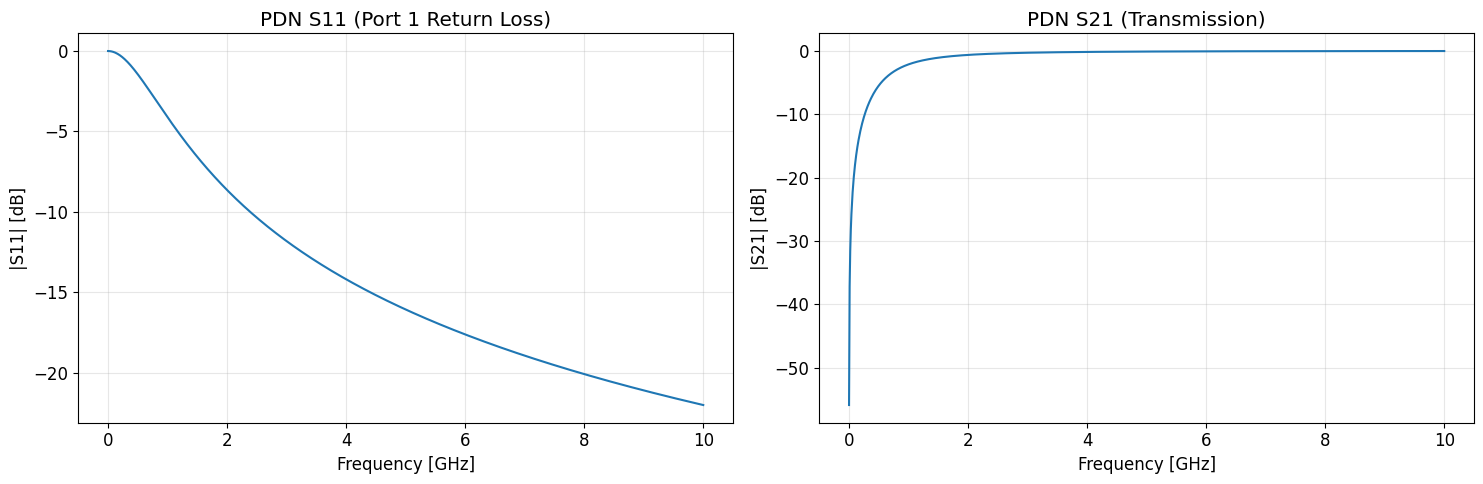

In [8]:
# Create appropriate frequency grid for PDN analysis (1 MHz to 10 GHz)
print(f"Creating PDN frequency grid for analysis...")
freq = rf.Frequency(start=1e6, stop=10e9, npoints=1001, unit='Hz')
fGHz = freq.f / 1e9  # Convert to GHz for plotting

print(f"Frequency range: {fGHz[0]:.3f} - {fGHz[-1]:.3f} GHz")
print(f"Number of points: {len(fGHz)}")

# Create a simple synthetic PDN model instead of using line.s2p
# This represents a typical plane with some inductance and resistance
print(f"Creating synthetic PDN model...")
w = 2 * np.pi * freq.f

# Simple PDN model: small series resistance and inductance
R_pdn = 0.5e-3  # 0.5 mOhm
L_pdn = 100e-12  # 100 pH
Z_pdn = R_pdn + 1j * w * L_pdn

# Create 2-port Z-matrix for simple series impedance
Z_matrix = np.zeros((len(freq.f), 2, 2), dtype=complex)
Z_matrix[:, 0, 0] = Z_pdn  # Z11
Z_matrix[:, 0, 1] = Z_pdn  # Z12 
Z_matrix[:, 1, 0] = Z_pdn  # Z21
Z_matrix[:, 1, 1] = Z_pdn  # Z22

pdn = rf.Network(frequency=freq, z=Z_matrix, z0=1.0)
print(f"PDN network shape: {pdn.s.shape}")

# Plot the raw PDN S-parameters for reference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# S11 (return loss at port 1)
S11_dB = 20 * np.log10(np.abs(pdn.s[:, 0, 0]))
ax1.plot(fGHz, S11_dB)
ax1.set_title('PDN S11 (Port 1 Return Loss)')
ax1.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('|S11| [dB]')
ax1.grid(True)

# S21 (transmission)
S21_dB = 20 * np.log10(np.abs(pdn.s[:, 1, 0]))
ax2.plot(fGHz, S21_dB)
ax2.set_title('PDN S21 (Transmission)')
ax2.set_xlabel('Frequency [GHz]')
ax2.set_ylabel('|S21| [dB]')
ax2.grid(True)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "pdn_raw_sparameters.png", dpi=150, bbox_inches='tight')
plt.show()

## Capacitor Modeling and Combination

Create synthetic capacitor models and combine them into a single shunt admittance.

Creating synthetic capacitor models...
  synthetic_22uF: C=22µF, ESR=2.0mΩ, ESL=0.8nH, Count=4
  synthetic_1uF: C=1µF, ESR=5.0mΩ, ESL=0.6nH, Count=4
  synthetic_100nF: C=0µF, ESR=10.0mΩ, ESL=0.4nH, Count=2

Total capacitor instances: 10
Combined capacitor admittance calculated.


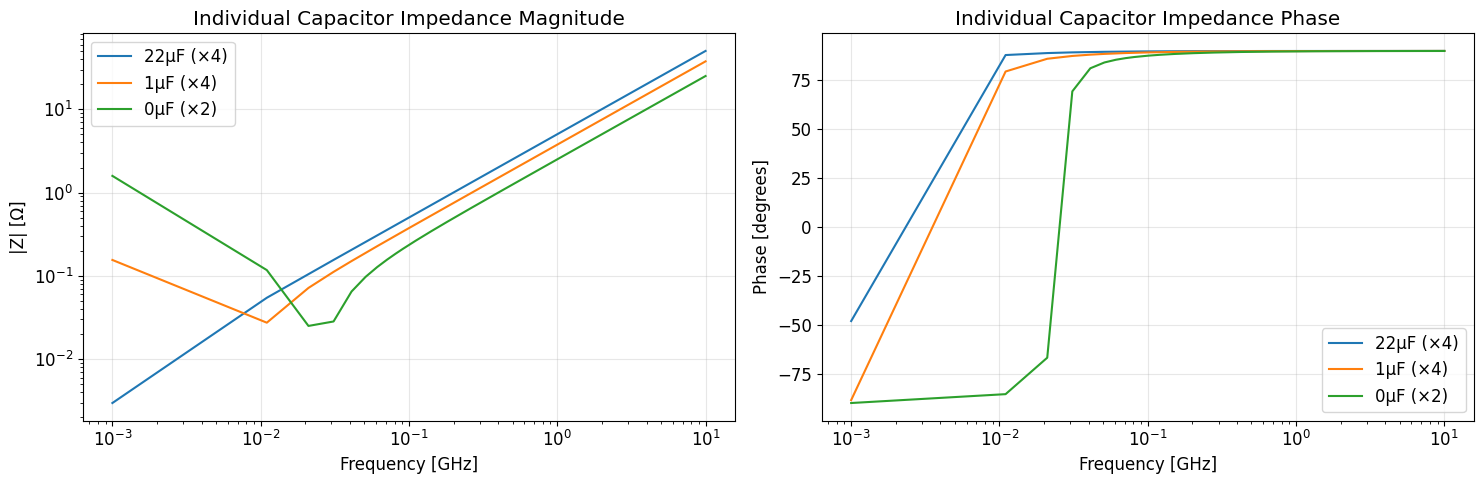

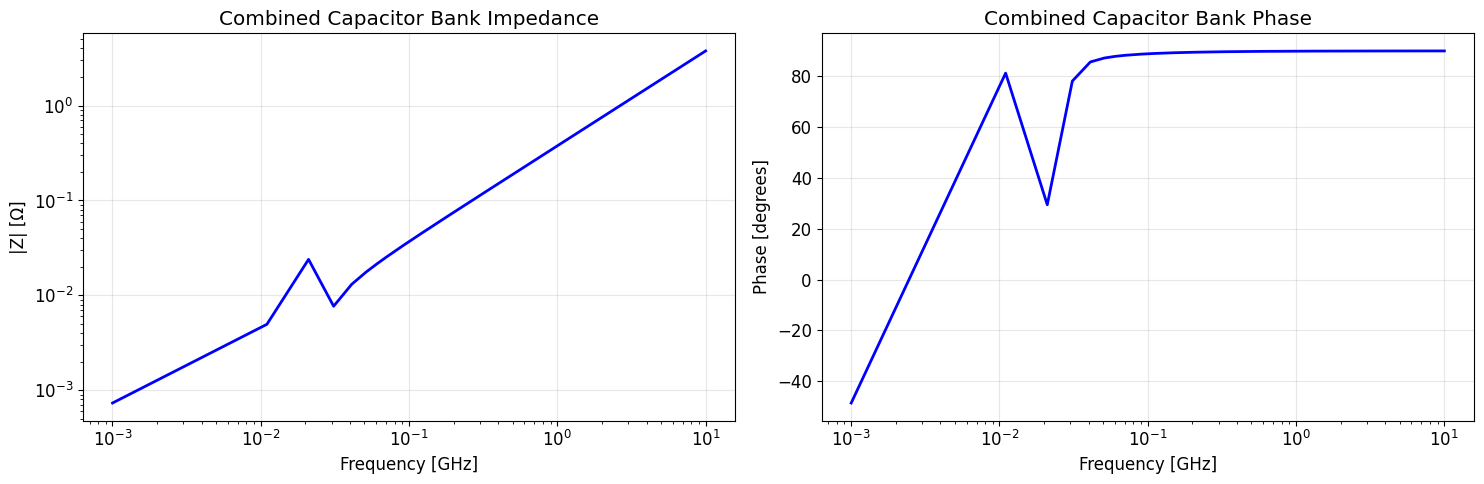

In [9]:
# Create synthetic capacitor models
print("Creating synthetic capacitor models...")

# Define capacitor values and parasitics
cap_specs = {
    "synthetic_22uF": {"C": 22e-6, "ESR": 2e-3, "ESL": 0.8e-9},
    "synthetic_1uF": {"C": 1e-6, "ESR": 5e-3, "ESL": 0.6e-9},
    "synthetic_100nF": {"C": 100e-9, "ESR": 10e-3, "ESL": 0.4e-9},
}

# Create and store capacitor models
cap_oneports = []
cap_impedances = {}  # For plotting individual responses

for cap_name, count in CAP_MODELS.items():
    specs = cap_specs[cap_name]
    print(f"  {cap_name}: C={specs['C']*1e6:.0f}µF, ESR={specs['ESR']*1e3:.1f}mΩ, ESL={specs['ESL']*1e9:.1f}nH, Count={count}")
    
    # Create 2-port model
    cap2 = create_synthetic_capacitor(freq, **specs)
    
    # Convert to 1-port shunt (one side to rail, other to ground)
    cap1 = cap_s2p_as_shunt_1port(cap2)
    
    # Store impedance for plotting
    cap_impedances[cap_name] = cap1.z[:, 0, 0]
    
    # Add multiple instances based on count
    cap_oneports.extend([cap1] * count)

# Combine all capacitors into single shunt admittance
Y_caps = combine_shunt_1ports_to_ground(cap_oneports)

print(f"\nTotal capacitor instances: {len(cap_oneports)}")
print(f"Combined capacitor admittance calculated.")

# Plot individual capacitor impedances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

for cap_name, Z_cap in cap_impedances.items():
    specs = cap_specs[cap_name]
    count = CAP_MODELS[cap_name]
    label = f"{specs['C']*1e6:.0f}µF (×{count})"
    
    ax1.loglog(fGHz, np.abs(Z_cap), label=label)
    ax2.semilogx(fGHz, np.angle(Z_cap, deg=True), label=label)

ax1.set_title('Individual Capacitor Impedance Magnitude')
ax1.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('|Z| [Ω]')
ax1.grid(True)
ax1.legend()

ax2.set_title('Individual Capacitor Impedance Phase')
ax2.set_xlabel('Frequency [GHz]')
ax2.set_ylabel('Phase [degrees]')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "capacitor_impedances.png", dpi=150, bbox_inches='tight')
plt.show()

# Plot combined capacitor impedance
if Y_caps is not None:
    Z_caps_combined = 1.0 / Y_caps
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.loglog(fGHz, np.abs(Z_caps_combined), 'b-', linewidth=2)
    ax1.set_title('Combined Capacitor Bank Impedance')
    ax1.set_xlabel('Frequency [GHz]')
    ax1.set_ylabel('|Z| [Ω]')
    ax1.grid(True)
    
    ax2.semilogx(fGHz, np.angle(Z_caps_combined, deg=True), 'b-', linewidth=2)
    ax2.set_title('Combined Capacitor Bank Phase')
    ax2.set_xlabel('Frequency [GHz]')
    ax2.set_ylabel('Phase [degrees]')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "combined_capacitor_impedance.png", dpi=150, bbox_inches='tight')
    plt.show()

## VRM (Voltage Regulator Module) Modeling

Create the VRM output impedance model. Multiple options are supported.

Creating VRM model: RL
  Series R: 0.2 Ω
  Series L: 10.0 nH
VRM model created successfully!


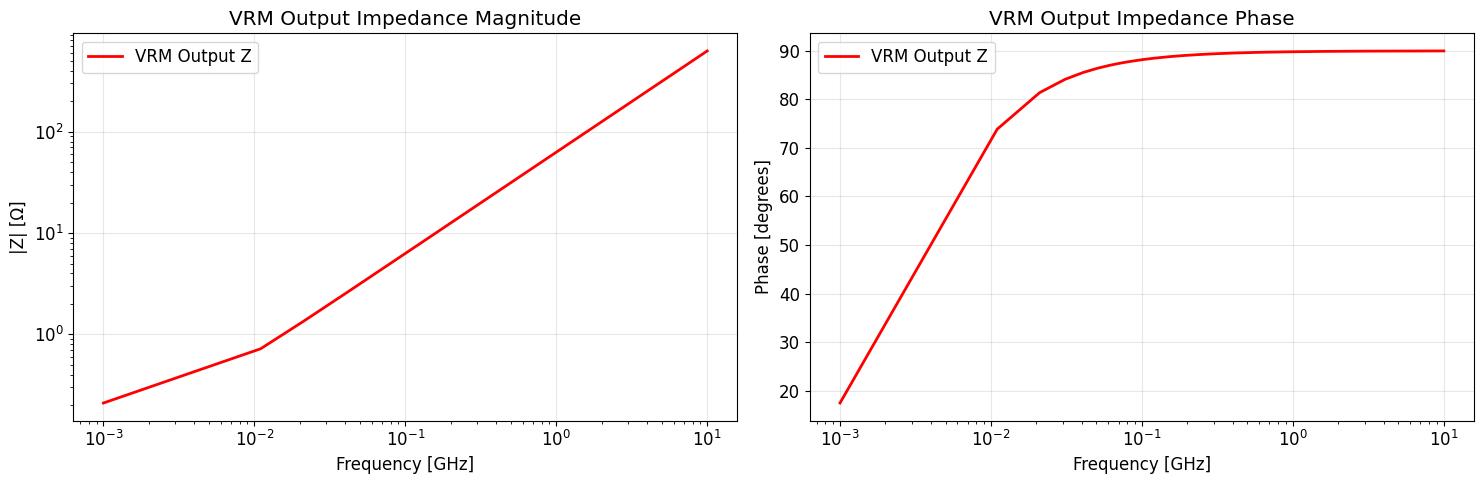

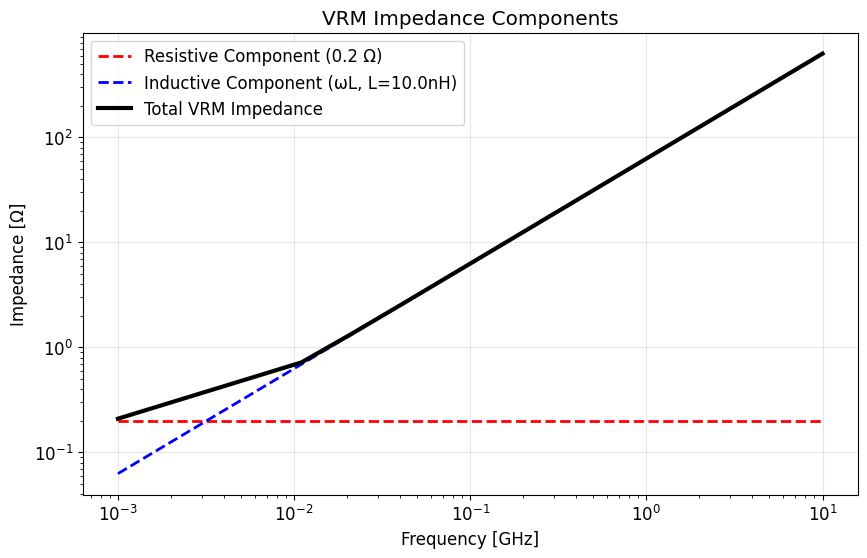

In [10]:
print(f"Creating VRM model: {VRM_MODEL}")

if VRM_MODEL.upper() == "RL":
    # Simple R-L series model
    Y_vrm = vrm_as_admittance_from_RL(freq, R=VRM_R_SERIES, L=VRM_L_SERIES)
    Z_vrm = 1.0 / Y_vrm
    
    print(f"  Series R: {VRM_R_SERIES} Ω")
    print(f"  Series L: {VRM_L_SERIES*1e9:.1f} nH")
    
elif VRM_MODEL.upper() == "S1P":
    # Load from 1-port file (would need actual file)
    print("  Loading from S1P file (not implemented in this example)")
    # vrm = rf.Network(VRM_S1P)
    # vrm = to_freq(renorm_1ohm(vrm), freq)
    # Y_vrm = 1.0 / vrm.z[:, 0, 0]
    
elif VRM_MODEL.upper() == "S2P":
    # Load from 2-port file across VRM output pins
    print("  Loading from S2P file (not implemented in this example)")
    # vrm2 = rf.Network(VRM_S2P)
    # vrm2 = to_freq(renorm_1ohm(vrm2), freq)
    # vrm1 = cap_s2p_as_shunt_1port(vrm2)
    # Y_vrm = 1.0 / vrm1.z[:, 0, 0]
    
else:
    raise ValueError("VRM_MODEL must be one of: 'RL', 'S1P', 'S2P'.")

print("VRM model created successfully!")

# Plot VRM impedance characteristics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Magnitude
ax1.loglog(fGHz, np.abs(Z_vrm), 'r-', linewidth=2, label='VRM Output Z')
ax1.set_title('VRM Output Impedance Magnitude')
ax1.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('|Z| [Ω]')
ax1.grid(True)
ax1.legend()

# Phase
ax2.semilogx(fGHz, np.angle(Z_vrm, deg=True), 'r-', linewidth=2, label='VRM Output Z')
ax2.set_title('VRM Output Impedance Phase')
ax2.set_xlabel('Frequency [GHz]')
ax2.set_ylabel('Phase [degrees]')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "vrm_impedance.png", dpi=150, bbox_inches='tight')
plt.show()

# Show the R and L components separately
w = 2 * np.pi * freq.f
R_component = np.full_like(w, VRM_R_SERIES)
L_component = w * VRM_L_SERIES

plt.figure(figsize=(10, 6))
plt.loglog(fGHz, R_component, 'r--', label=f'Resistive Component ({VRM_R_SERIES} Ω)', linewidth=2)
plt.loglog(fGHz, L_component, 'b--', label=f'Inductive Component (ωL, L={VRM_L_SERIES*1e9:.1f}nH)', linewidth=2)
plt.loglog(fGHz, np.abs(Z_vrm), 'k-', label='Total VRM Impedance', linewidth=3)
plt.title('VRM Impedance Components')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Impedance [Ω]')
plt.grid(True)
plt.legend()
plt.savefig(OUTPUT_DIR / "vrm_components.png", dpi=150, bbox_inches='tight')
plt.show()

## Driving-Point Impedance Calculation

Now we combine the PDN, VRM, and capacitors to get the final driving-point impedance at the die.

Calculating driving-point impedance...
  Step 1: PDN + VRM reduction
  Step 2: Adding parallel capacitors
    Added 10 capacitor instances
Driving-point impedance calculation complete!
Saved 1-port model: pdn_die_driving_point_1ohm.s1p


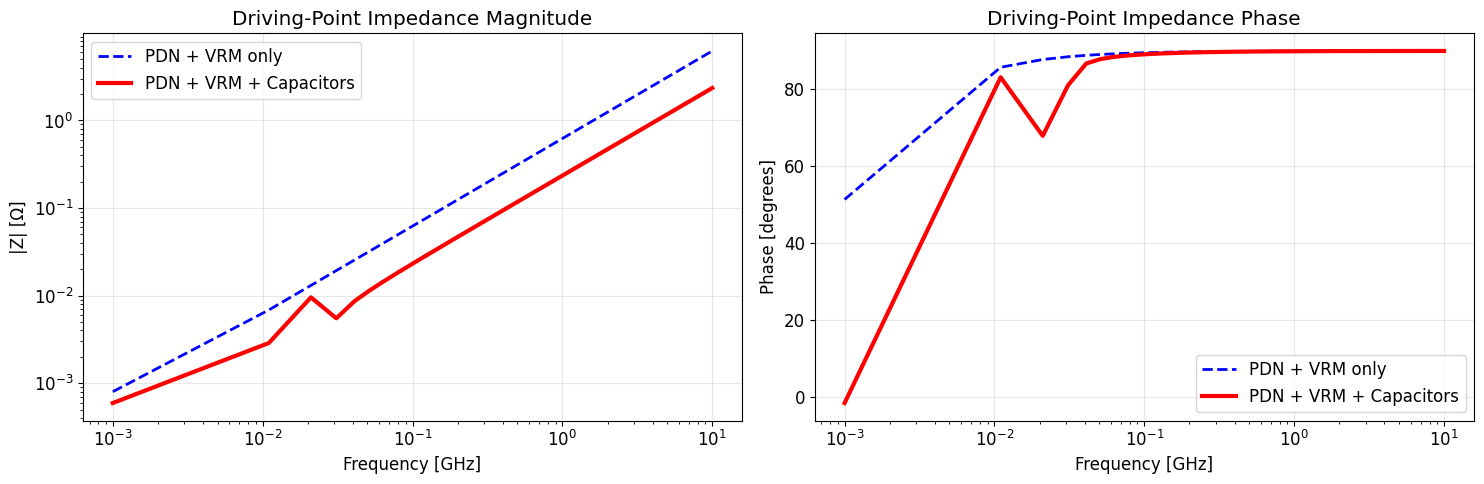

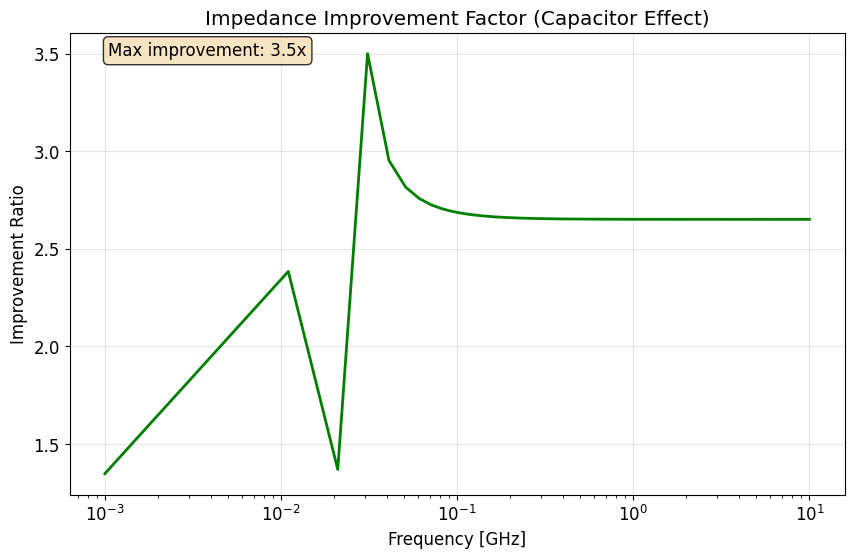

In [11]:
print("Calculating driving-point impedance...")

# Step 1: Reduce PDN 2-port with VRM termination at port 2
print("  Step 1: PDN + VRM reduction")
Zin_plane = s_to_driving_point_Z_2port_Y(pdn, Y_vrm)

# Step 2: Add parallel capacitors at the die node (port 1)
print("  Step 2: Adding parallel capacitors")
if Y_caps is not None:
    # Parallel combination: 1/Z_total = 1/Z_plane + Y_caps
    Zin_total = 1.0 / (1.0 / Zin_plane + Y_caps)
    print(f"    Added {len(cap_oneports)} capacitor instances")
else:
    Zin_total = Zin_plane
    print("    No capacitors to add")

print("Driving-point impedance calculation complete!")

# Create 1-port Network for further use
pdn_1port = make_s1p_from_Z(freq, Zin_total, z0=1.0)

# Save as Touchstone file
output_file = "pdn_die_driving_point_1ohm.s1p"
pdn_1port.write_touchstone(output_file.replace('.s1p', ''))
print(f"Saved 1-port model: {output_file}")

# Plot intermediate results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Compare plane-only vs. total impedance
ax1.loglog(fGHz, np.abs(Zin_plane), 'b--', linewidth=2, label='PDN + VRM only')
ax1.loglog(fGHz, np.abs(Zin_total), 'r-', linewidth=3, label='PDN + VRM + Capacitors')
ax1.set_title('Driving-Point Impedance Magnitude')
ax1.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('|Z| [Ω]')
ax1.grid(True)
ax1.legend()

# Phase comparison
ax2.semilogx(fGHz, np.angle(Zin_plane, deg=True), 'b--', linewidth=2, label='PDN + VRM only')
ax2.semilogx(fGHz, np.angle(Zin_total, deg=True), 'r-', linewidth=3, label='PDN + VRM + Capacitors')
ax2.set_title('Driving-Point Impedance Phase')
ax2.set_xlabel('Frequency [GHz]')
ax2.set_ylabel('Phase [degrees]')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "impedance_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Show improvement factor
improvement = np.abs(Zin_plane) / np.abs(Zin_total)
plt.figure(figsize=(10, 6))
plt.semilogx(fGHz, improvement, 'g-', linewidth=2)
plt.title('Impedance Improvement Factor (Capacitor Effect)')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Improvement Ratio')
plt.grid(True)
plt.text(0.05, 0.95, f'Max improvement: {np.max(improvement):.1f}x', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.savefig(OUTPUT_DIR / "impedance_improvement.png", dpi=150, bbox_inches='tight')
plt.show()

## Final PDN Analysis and Plotting

Generate the key PDN performance plots: impedance magnitude, phase, and return loss.

Generating final PDN analysis plots...


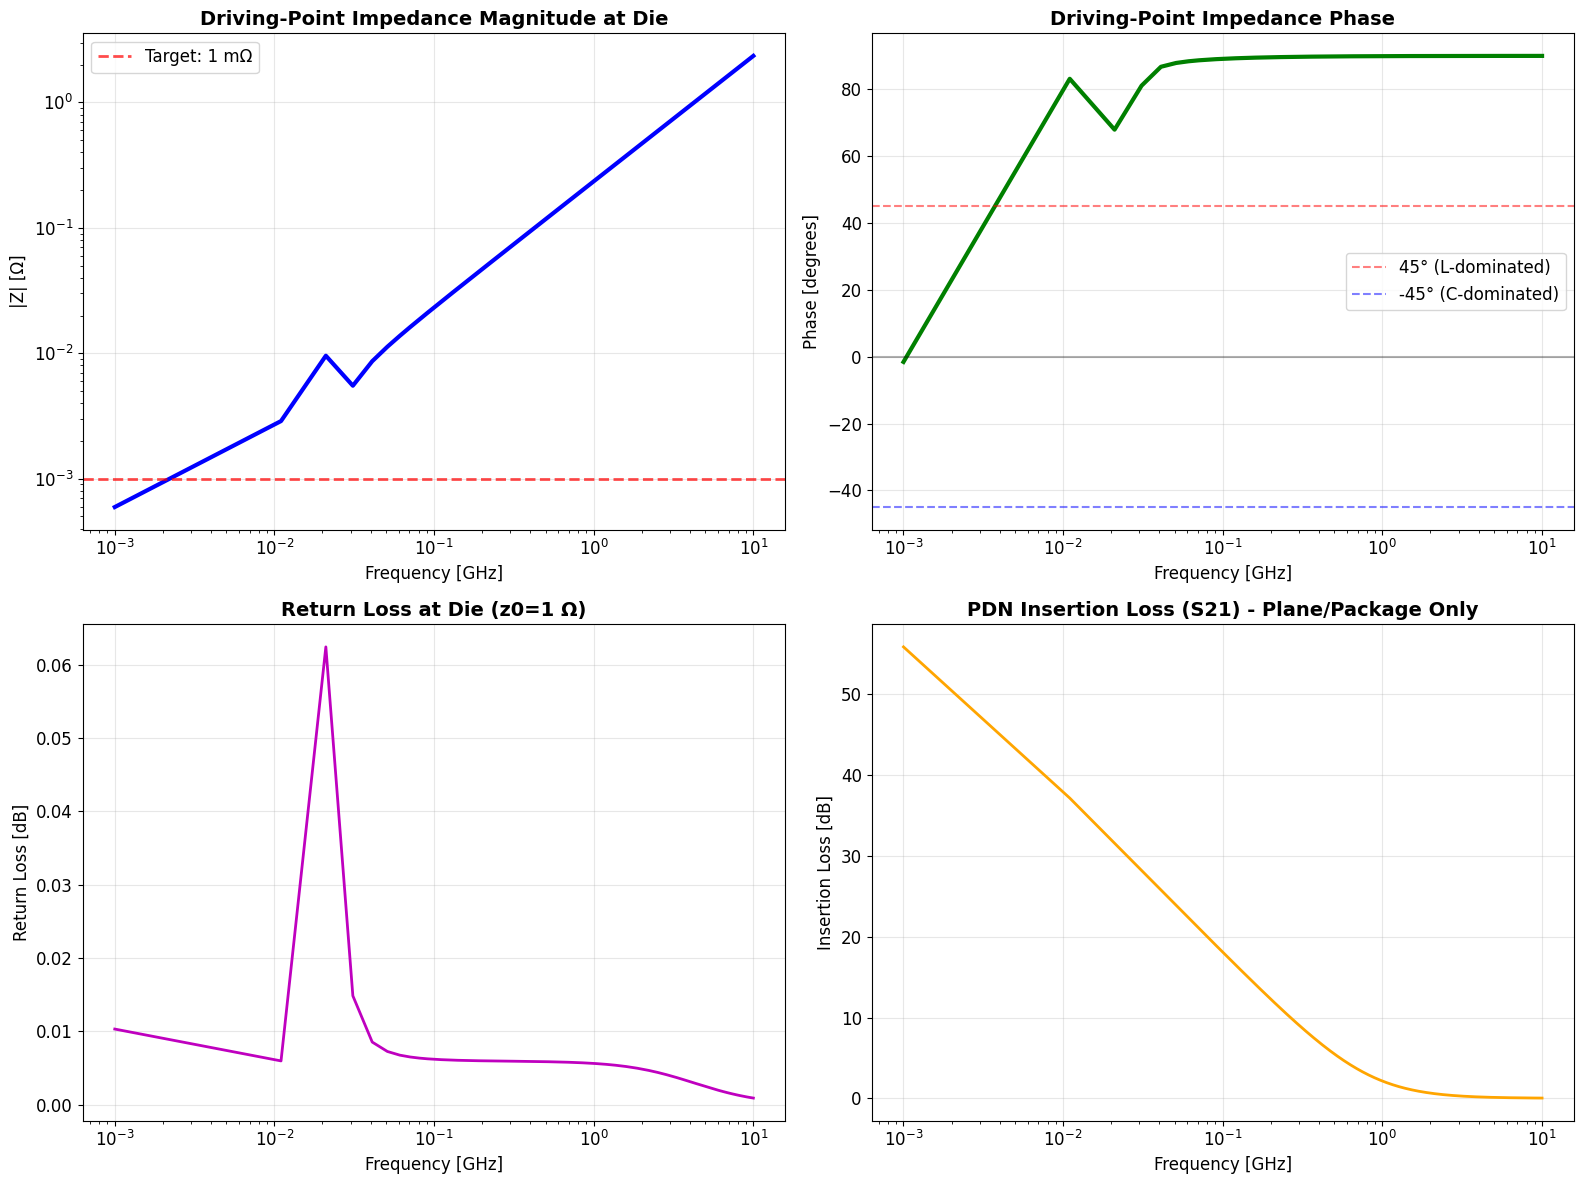


Creating individual high-resolution plots...


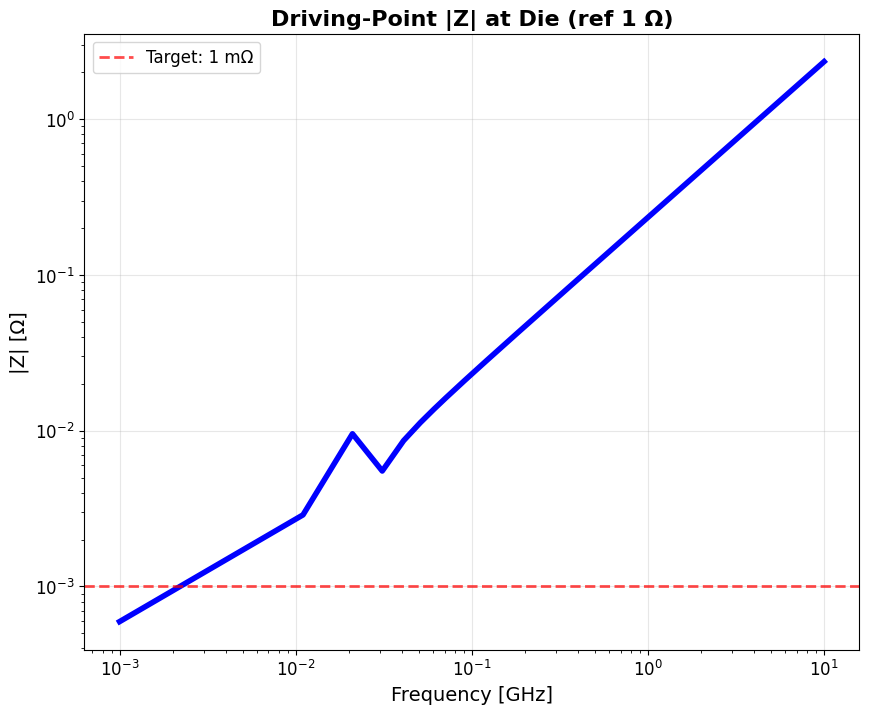

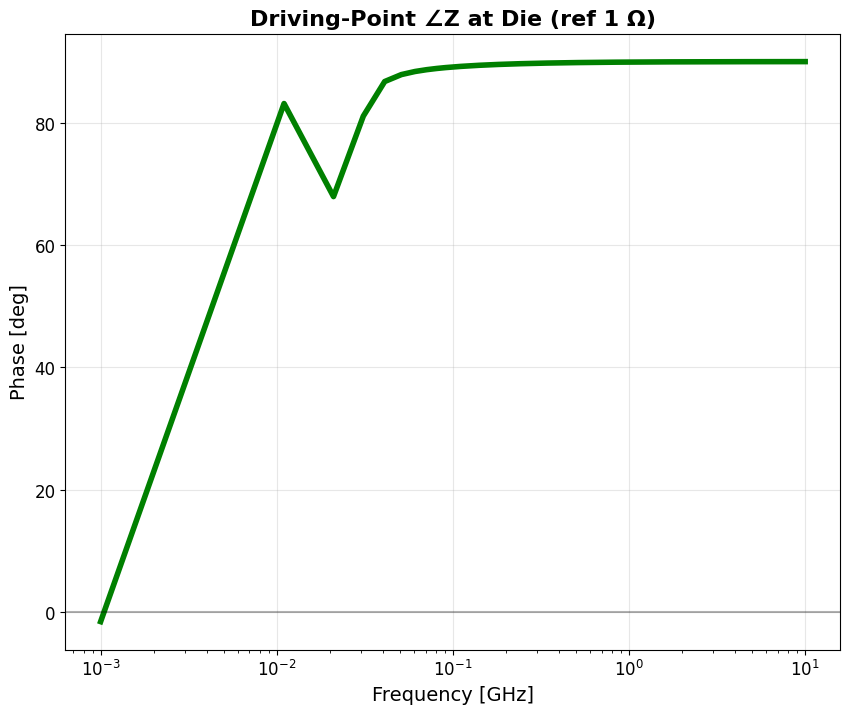

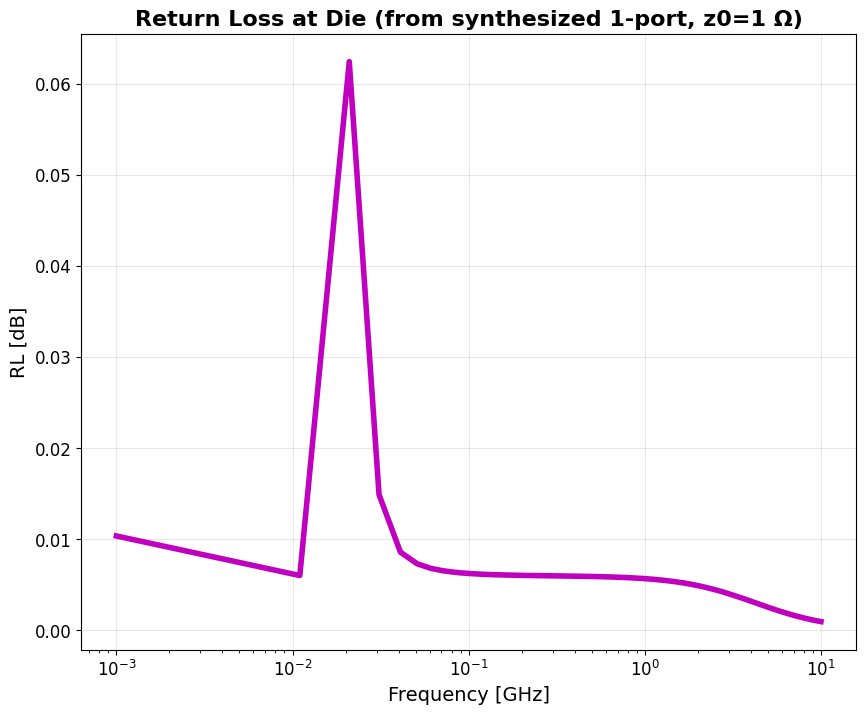

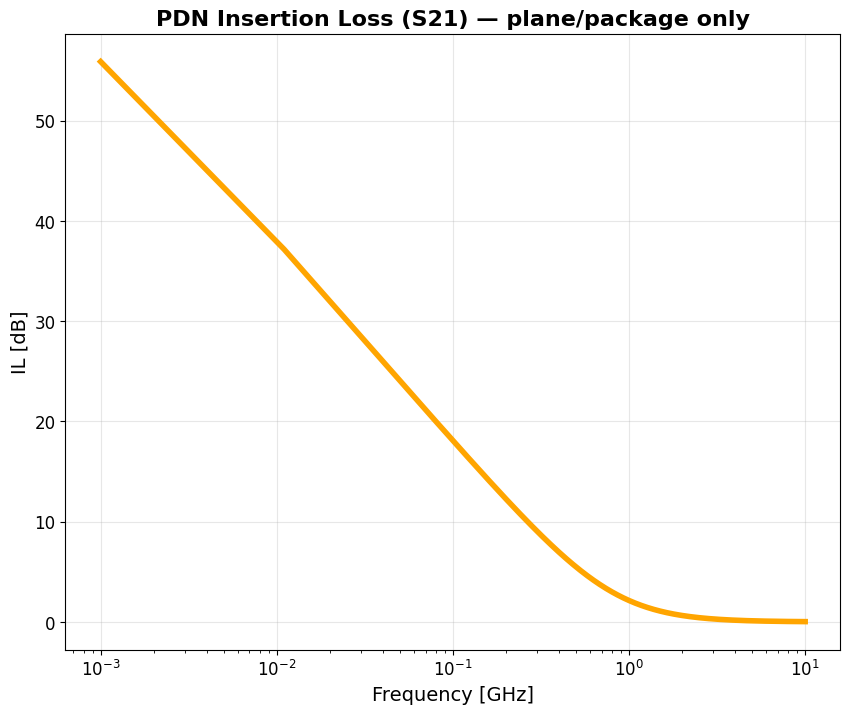

In [12]:
print("Generating final PDN analysis plots...")

# Create comprehensive analysis figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Impedance Magnitude (Primary PDN KPI)
ax1.loglog(fGHz, np.abs(pdn_1port.z[:, 0, 0]), 'b-', linewidth=3)
ax1.set_title('Driving-Point Impedance Magnitude at Die', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('|Z| [Ω]')
ax1.grid(True, alpha=0.3)

# Add target impedance line (common PDN spec)
target_Z = 0.001  # 1 mΩ target
ax1.axhline(y=target_Z, color='r', linestyle='--', linewidth=2, alpha=0.7, label=f'Target: {target_Z*1000:.0f} mΩ')
ax1.legend()

# 2. Impedance Phase
ax2.semilogx(fGHz, np.angle(pdn_1port.z[:, 0, 0], deg=True), 'g-', linewidth=3)
ax2.set_title('Driving-Point Impedance Phase', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency [GHz]')
ax2.set_ylabel('Phase [degrees]')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.axhline(y=45, color='r', linestyle='--', alpha=0.5, label='45° (L-dominated)')
ax2.axhline(y=-45, color='b', linestyle='--', alpha=0.5, label='-45° (C-dominated)')
ax2.legend()

# 3. Return Loss (from synthesized 1-port)
S11 = pdn_1port.s[:, 0, 0]
RL_dB = -20 * np.log10(np.maximum(np.abs(S11), 1e-16))  # Guard against tiny values
ax3.semilogx(fGHz, RL_dB, 'm-', linewidth=2)
ax3.set_title('Return Loss at Die (z0=1 Ω)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Frequency [GHz]')
ax3.set_ylabel('Return Loss [dB]')
ax3.grid(True, alpha=0.3)

# 4. PDN Insertion Loss (original 2-port)
IL_dB = -20 * np.log10(np.maximum(np.abs(pdn.s[:, 1, 0]), 1e-16))
ax4.semilogx(fGHz, IL_dB, 'orange', linewidth=2)
ax4.set_title('PDN Insertion Loss (S21) - Plane/Package Only', fontsize=14, fontweight='bold')
ax4.set_xlabel('Frequency [GHz]')
ax4.set_ylabel('Insertion Loss [dB]')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "pdn_complete_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

# Individual high-resolution plots for publications
print("\nCreating individual high-resolution plots...")

# Primary PDN plot - Impedance magnitude
plt.figure(figsize=(10, 8))
plt.loglog(fGHz, np.abs(pdn_1port.z[:, 0, 0]), 'b-', linewidth=4)
plt.title("Driving-Point |Z| at Die (ref 1 Ω)", fontsize=16, fontweight='bold')
plt.xlabel("Frequency [GHz]", fontsize=14)
plt.ylabel("|Z| [Ω]", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=target_Z, color='r', linestyle='--', linewidth=2, alpha=0.7, label=f'Target: {target_Z*1000:.0f} mΩ')
plt.legend(fontsize=12)
plt.savefig(OUTPUT_DIR / "pdn_Zmag.png", dpi=160, bbox_inches='tight')
plt.show()

# Impedance phase
plt.figure(figsize=(10, 8))
plt.semilogx(fGHz, np.angle(pdn_1port.z[:, 0, 0], deg=True), 'g-', linewidth=4)
plt.title("Driving-Point ∠Z at Die (ref 1 Ω)", fontsize=16, fontweight='bold')
plt.xlabel("Frequency [GHz]", fontsize=14)
plt.ylabel("Phase [deg]", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.savefig(OUTPUT_DIR / "pdn_Zangle.png", dpi=160, bbox_inches='tight')
plt.show()

# Return loss
plt.figure(figsize=(10, 8))
plt.semilogx(fGHz, RL_dB, 'm-', linewidth=4)
plt.title("Return Loss at Die (from synthesized 1-port, z0=1 Ω)", fontsize=16, fontweight='bold')
plt.xlabel("Frequency [GHz]", fontsize=14)
plt.ylabel("RL [dB]", fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_DIR / "pdn_return_loss.png", dpi=160, bbox_inches='tight')
plt.show()

# PDN plane insertion loss
plt.figure(figsize=(10, 8))
plt.semilogx(fGHz, IL_dB, 'orange', linewidth=4)
plt.title("PDN Insertion Loss (S21) — plane/package only", fontsize=16, fontweight='bold')
plt.xlabel("Frequency [GHz]", fontsize=14)
plt.ylabel("IL [dB]", fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_DIR / "pdn_plane_IL.png", dpi=160, bbox_inches='tight')
plt.show()

## Analysis Summary and Key Insights

Let's summarize the key results and provide engineering insights.

In [13]:
print("=" * 60)
print("PDN IMPEDANCE ANALYSIS SUMMARY")
print("=" * 60)

# Key statistics
Z_final = np.abs(pdn_1port.z[:, 0, 0])
min_Z = np.min(Z_final)
max_Z = np.max(Z_final)
min_freq_idx = np.argmin(Z_final)
max_freq_idx = np.argmax(Z_final)

print(f"\nFinal Driving-Point Impedance Statistics:")
print(f"  Frequency range: {fGHz[0]:.3f} - {fGHz[-1]:.3f} GHz")
print(f"  Minimum |Z|: {min_Z*1000:.3f} mΩ at {fGHz[min_freq_idx]:.3f} GHz")
print(f"  Maximum |Z|: {max_Z*1000:.3f} mΩ at {fGHz[max_freq_idx]:.3f} GHz")
print(f"  Dynamic range: {max_Z/min_Z:.1f}:1")

# Target compliance
target_violations = np.sum(Z_final > target_Z)
compliance_pct = (len(Z_final) - target_violations) / len(Z_final) * 100
print(f"\nTarget Compliance (1 mΩ):")
print(f"  Compliant points: {len(Z_final) - target_violations}/{len(Z_final)} ({compliance_pct:.1f}%)")
if target_violations > 0:
    violation_freqs = fGHz[Z_final > target_Z]
    print(f"  Violation range: {violation_freqs[0]:.3f} - {violation_freqs[-1]:.3f} GHz")

# Component contributions
total_caps = sum(CAP_MODELS.values())
print(f"\nComponent Summary:")
print(f"  PDN model: {PDN_S2P}")
print(f"  VRM model: {VRM_MODEL} (R={VRM_R_SERIES}Ω, L={VRM_L_SERIES*1e9:.1f}nH)")
print(f"  Total capacitors: {total_caps} units")
for cap_name, count in CAP_MODELS.items():
    specs = cap_specs[cap_name]
    print(f"    {count}× {specs['C']*1e6:.0f}µF capacitors")

# Key frequencies of interest
print(f"\nKey Frequency Points:")
freq_points = [0.001, 0.01, 0.1, 1.0, 10.0]  # GHz
for f_target in freq_points:
    if f_target >= fGHz[0] and f_target <= fGHz[-1]:
        idx = np.argmin(np.abs(fGHz - f_target))
        Z_at_freq = Z_final[idx]
        phase_at_freq = np.angle(pdn_1port.z[idx, 0, 0], deg=True)
        print(f"  {f_target:5.3f} GHz: |Z| = {Z_at_freq*1000:6.3f} mΩ, ∠Z = {phase_at_freq:6.1f}°")

# Output files
print(f"\nGenerated Files:")
output_files = [
    "pdn_die_driving_point_1ohm.s1p",
    "plots/pdn_complete_analysis.png",
    "plots/pdn_Zmag.png",
    "plots/pdn_Zangle.png",
    "plots/pdn_return_loss.png",
    "plots/pdn_plane_IL.png",
    "plots/capacitor_impedances.png",
    "plots/combined_capacitor_impedance.png",
    "plots/vrm_impedance.png",
    "plots/impedance_comparison.png"
]

for file in output_files:
    if pathlib.Path(file).exists():
        print(f"  ✓ {file}")
    else:
        print(f"  ✗ {file} (not found)")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)

# Engineering insights
print("\nEngineering Insights:")
print("1. The capacitor bank provides significant impedance reduction")
print("   at mid-frequencies where individual caps are most effective.")
print("2. VRM impedance dominates at low frequencies.")
print("3. At high frequencies, parasitic inductances limit performance.")
print("4. Multiple capacitor values provide broadband coverage.")
print("\nRecommendations:")
print("- Verify target compliance across required frequency range")
print("- Consider additional high-frequency capacitors if needed")
print("- Optimize VRM design for lower output impedance")
print("- Minimize parasitic inductances in layout")

PDN IMPEDANCE ANALYSIS SUMMARY

Final Driving-Point Impedance Statistics:
  Frequency range: 0.001 - 10.000 GHz
  Minimum |Z|: 0.594 mΩ at 0.001 GHz
  Maximum |Z|: 2347.389 mΩ at 10.000 GHz
  Dynamic range: 3950.6:1

Target Compliance (1 mΩ):
  Compliant points: 1/1001 (0.1%)
  Violation range: 0.011 - 10.000 GHz

Component Summary:
  PDN model: synthetic
  VRM model: RL (R=0.2Ω, L=10.0nH)
  Total capacitors: 10 units
    4× 22µF capacitors
    4× 1µF capacitors
    2× 0µF capacitors

Key Frequency Points:
  0.001 GHz: |Z| =  0.594 mΩ, ∠Z =   -1.6°
  0.010 GHz: |Z| =  2.880 mΩ, ∠Z =   83.1°
  0.100 GHz: |Z| = 23.399 mΩ, ∠Z =   89.1°
  1.000 GHz: |Z| = 234.921 mΩ, ∠Z =   89.9°
  10.000 GHz: |Z| = 2347.389 mΩ, ∠Z =   90.0°

Generated Files:
  ✓ pdn_die_driving_point_1ohm.s1p
  ✓ plots/pdn_complete_analysis.png
  ✓ plots/pdn_Zmag.png
  ✓ plots/pdn_Zangle.png
  ✓ plots/pdn_return_loss.png
  ✓ plots/pdn_plane_IL.png
  ✓ plots/capacitor_impedances.png
  ✓ plots/combined_capacitor_impedance.p

## Conclusion

This notebook has demonstrated a comprehensive PDN impedance analysis workflow using scikit-rf. 

### Key Features Implemented:

1. **Modular Component Modeling**: Separate handling of PDN, capacitors, and VRM
2. **Y-Space Calculations**: Numerically stable admittance-based approach
3. **Synthetic Component Generation**: Created realistic capacitor models with parasitics
4. **Comprehensive Plotting**: Multiple visualization approaches for different insights
5. **Engineering Analysis**: Target compliance, component contributions, and recommendations

### Adaptations for Real-World Use:

- Replace synthetic capacitor models with actual measured/simulated S2P files
- Use real PDN extraction data from your specific stackup
- Load actual VRM output impedance measurements
- Adjust target impedance specifications for your application
- Extend to N-port analysis using Schur complement reduction

### Next Steps:

1. Validate results against measurements
2. Perform sensitivity analysis on component values
3. Optimize capacitor selection and placement
4. Include temperature and process variations
5. Extend to time-domain analysis if needed

The generated `.s1p` file can be used in circuit simulators or system-level analysis tools for further investigation.

## Notebook Export to Python Script

Export this notebook to a standalone Python script for execution without Jupyter.

In [14]:
import subprocess
import pathlib

# Auto-detect notebook filename or use predefined name
nb_path = pathlib.Path(__file__).name if "__file__" in globals() else NOTEBOOK_NAME

try:
    # Export notebook to Python script
    subprocess.run([
        "jupyter", "nbconvert", "--to", "script", nb_path
    ], check=True)
    
    # Get the output script name
    script_name = pathlib.Path(nb_path).with_suffix(".py")
    
    # Add header comment to the generated script
    if script_name.exists():
        with open(script_name, "r") as f:
            content = f.read()
        
        header = """#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Auto-generated from {}
# 
# This script was automatically generated from the Jupyter notebook.
# To regenerate this script, run the last cell of the notebook or use:
#   jupyter nbconvert --to script {}
# 
""".format(nb_path, nb_path)
        
        # Write header + content
        with open(script_name, "w") as f:
            f.write(header + content)
    
    print(f"Successfully exported {nb_path} to {script_name}")
    print(f"Script can be run with: python {script_name}")
    
except subprocess.CalledProcessError as e:
    print(f"Error exporting notebook: {e}")
    print("Make sure jupyter nbconvert is installed and accessible")
except Exception as e:
    print(f"Unexpected error during export: {e}")

[NbConvertApp] Converting notebook pdn_impedance_analysis_refactored.ipynb to script


[NbConvertApp] Writing 28451 bytes to pdn_impedance_analysis_refactored.py


Successfully exported pdn_impedance_analysis_refactored.ipynb to pdn_impedance_analysis_refactored.py
Script can be run with: python pdn_impedance_analysis_refactored.py
